# LuisNet Car detection
## Cargar librerías

In [1]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,Input, Dropout
from tensorflow.keras.models import Model,Sequential
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import io
import os
from tensorflow.keras.preprocessing.image import img_to_array,load_img
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
import random
import imutils

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

## Cargar imágenes y datos
### Cargar imágenes
Pueden descargarse directamente desde Kaggle o del Google Drive.

In [2]:
# Conectarse a carpetas de gdrive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [7]:
# Conectarse a Appi de Kaggle
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                             Spotify and Youtube                                 9MB  2023-03-20 15:43:25           8051        297  1.0              
ppb00x/country-gdp                                                Country_GDP                                         7KB  2023-04-07 06:47:36           1052         33  1.0              
erdemtaha/cancer-data                                             Cancer Data                                        49KB  2023-03-22 07:57:00           3

In [9]:
!kaggle datasets download -d sshikamaru/car-object-detection

 98% 110M/112M [00:03<00:00, 28.8MB/s]
100% 112M/112M [00:03<00:00, 31.0MB/s]


In [10]:
!mkdir -p dataset #&& cd dataset && unzip car-object-detection.zip

In [11]:
#L: Esta función descomprime el fichero .zip y lo guarda en la carpeta 'dataset'
import zipfile
zip_ref = zipfile.ZipFile('car-object-detection.zip', 'r')
zip_ref.extractall('dataset')
zip_ref.close()

In [12]:
#https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

100% 1.82G/1.82G [00:55<00:00, 30.5MB/s]
100% 1.82G/1.82G [00:55<00:00, 35.6MB/s]


In [13]:
zip_ref = zipfile.ZipFile('stanford-cars-dataset.zip', 'r')
zip_ref.extractall('dataset')
zip_ref.close()

### Cargar datos

In [14]:
# rutas descargando desde Kaggle
ruta_sf = "/content/dataset/cars_train/cars_train/"
ruta_cod = '/content/dataset/data/training_images/'

# rutas de Gdrive
# ruta_sf = "/content/gdrive/MyDrive/Trabajo DO/car_detection/standford_cardataset/cars_train/cars_train/"
# ruta_cod = '/content/gdrive/MyDrive/Trabajo DO/car_detection/car_object_detection/training_images/'

In [21]:
#df = pd.read_excel("/Users/luispalma/Documentos/Master en IA3/2. Aprendijaze Profundo I/Trabajo final de DO/car_detection/df_train.xlsx")
df = pd.read_excel("df_train.xlsx")
df = df.iloc[:,1:]
df.image = df.image.apply(lambda x: x.replace('standford_cardataset/cars_train/cars_train/', ruta_sf).\
                     replace('car_object_detection/training_images/', ruta_cod))
df

,image,xmin,ymin,xmax,ymax,label
0,/content/dataset/data/training_images/vid_4_10...,281,187,327,223,car
1,/content/dataset/data/training_images/vid_4_10...,15,187,120,236,car
2,/content/dataset/data/training_images/vid_4_10...,239,176,361,236,car
3,/content/dataset/data/training_images/vid_4_10...,496,172,630,231,car
4,/content/dataset/data/training_images/vid_4_10...,16,186,132,238,car
...,...,...,...,...,...,...
1237,/content/dataset/cars_train/cars_train/07197.jpg,5,51,256,146,car
1238,/content/dataset/cars_train/cars_train/07199.jpg,58,59,372,214,car
1239,/content/dataset/cars_train/cars_train/07200.jpg,13,56,1018,728,car
1240,/content/dataset/cars_train/cars_train/07201.jpg,86,103,485,380,car


## Dividir datos en conjunto train, test y val
Definición de cada uno de los subconjuntos:
+ Train: 75%
+ Val: 15%
+ Test: 10%

In [22]:
# Split of the data into train and test  
df_train, df_test = train_test_split(df,
                                     test_size=0.1,
                                     random_state=42)

# Split of the data into train and val 
df_train, df_val = train_test_split(df_train,
                                    test_size=0.16667,
                                    random_state=42)

print(f"train: {df_train.shape[0]} {df_train.shape[0]/df.shape[0]:.2%}\n \
val: {df_val.shape[0]} {df_val.shape[0]/df.shape[0]:.2%}\n \
test: {df_test.shape[0]} {df_test.shape[0]/df.shape[0]:.2%}")

train: 930 74.88%
 val: 187 15.06%
 test: 125 10.06%


### Conversión de imágenes a matrices de cada uno de los subconjuntos

In [23]:
def convert_images(df):

# Crear listas data, target y filename vacias y definir la ubicación de las imagenes de entrenamiento
  data=[]
  target=[]
  filename=[]

  # Convertir imágenes a arrays 
  for index,rows in df.iterrows():
      image_path, start_x, start_y, end_x, end_y, label = rows["image"], rows["xmin"], rows["ymin"], rows["xmax"], rows["ymax"], rows['label']
    
      image=cv2.imread(image_path)
      h,w,_=image.shape
      start_x=start_x/w
      start_y=start_y/h
      end_x=end_x/w
      end_y=end_y/h

      image=load_img(image_path,target_size=(224,224)) # Lo que hace esta función es redimensionar las imagenes para que sean de 224x224
      image=img_to_array(image)

      data.append(image)
      target.append((start_x,start_y,end_x,end_y))

  data=np.array(data,dtype="float32")/255
  targets=np.array(target,dtype="float32")
  return (data, targets)

In [24]:
train_images, train_targets = convert_images(df_train)
test_images, test_targets = convert_images(df_test)
val_images, val_targets = convert_images(df_val)

## Configuración de Modelos de detección de Objetos
### Modelo inicial model_1

In [25]:
model=Sequential()
model.add(tensorflow.keras.Input(shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(4,activation="sigmoid"))

opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [26]:
checkpoint_filepath = 'best_weights.hdf5'

earlyStop = EarlyStopping(monitor='val_accuracy', patience=15, 
                        verbose=1, mode='max',restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      save_weights_only=False, 
                                      monitor='val_accuracy',
                                      mode='max', 
                                      save_best_only=True)
learningrate = ReduceLROnPlateau(monitor='val_accuracy',
                                          mode='max',
                                          min_delta=0.03, patience=3, 
                                          factor=.5,
                                          min_lr=0.00001, verbose=1)

callbacks = [earlyStop, checkpoint, learningrate]

In [27]:
epochs = 10
hist = model.fit(train_images,
                train_targets,
                validation_data=(val_images,val_targets),
                batch_size=10,
                epochs=epochs,
                callbacks=callbacks,
                verbose=1)

Epoch 1/10
93/93 [==============================] - 43s 246ms/step - loss: 0.0548 - accuracy: 0.5914 - val_loss: 0.0510 - val_accuracy: 0.5775 - lr: 1.0000e-04
Epoch 2/10
93/93 [==============================] - 20s 216ms/step - loss: 0.0497 - accuracy: 0.5892 - val_loss: 0.0482 - val_accuracy: 0.5936 - lr: 1.0000e-04
Epoch 3/10
93/93 [==============================] - 20s 217ms/step - loss: 0.0483 - accuracy: 0.6387 - val_loss: 0.0465 - val_accuracy: 0.6578 - lr: 1.0000e-04
Epoch 4/10
93/93 [==============================] - 14s 145ms/step - loss: 0.0463 - accuracy: 0.6613 - val_loss: 0.0496 - val_accuracy: 0.5829 - lr: 1.0000e-04
Epoch 5/10
93/93 [==============================] - 13s 142ms/step - loss: 0.0449 - accuracy: 0.6441 - val_loss: 0.0440 - val_accuracy: 0.6203 - lr: 1.0000e-04
Epoch 6/10
93/93 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.6591
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
93/93 [=======================

47/47 [==============================] - 3s 36ms/step - loss: 0.0421 - accuracy: 0.7005
Error (test):0.0420958437025547
Accuracy (Test): 0.7005347609519958


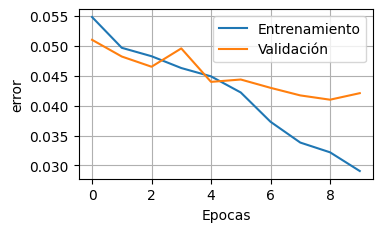

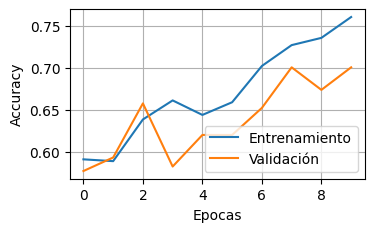

In [28]:
def plot_curves(history):
    plt.figure(figsize=(3.8,2.2))
    plt.xlabel('Epocas')
    plt.ylabel('error')
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid()
    plt.legend(['Entrenamiento', 'Validación'])

    plt.figure(figsize=(3.8,2.2))
    plt.xlabel('Epocas')
    plt.ylabel('Accuracy')
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.grid()
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right');

plot_curves(hist.history)
results = model.evaluate(val_images, val_targets, batch_size=4)
print(f'Error (test):{results[0]}\nAccuracy (Test): {results[1]}')

In [29]:
# Guardar el modelo
# model_1 = model
# model_1.save('model_1.h5')

# Cargar el modelo
model_1 = load_model('model_1.h5')

#### Métrica de rendimiento del modelo

In [30]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou    

def show_pred(df_test,model, a = None):
  # si a=None, escoger un valor aleatorio, sino: usar el declarado
  if a is None:
    a = random.randint(1, df_test.shape[0])
  else:
    a = df_test.loc[:a,].shape[0]

  plt.figure(figsize=(4,4))
  test_images, test_targets = convert_images(df_test.iloc[[a]])  
  boxpred = model.predict(np.expand_dims(test_images[0], axis=0))
  (startX, startY, endX, endY) = test_targets[0]
  im = df_test.image.iloc[a].split("/")[-1]
  iou = bb_intersection_over_union(boxpred[0], test_targets[0])
  thickness = 2
  test_image = cv2.imread(df_test["image"].iloc[a])
  (h,w) = test_image.shape[:2]

  #cv2.putText(test_image, "IoU: {:.2f}".format(iou), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, .9, (255, 0, 250), thickness)
  #BoundingBox obs
  startX=int(startX*w)
  startY=int(startY*h)
  endX=int(endX*w)
  endY=int(endY*h)
  opt1=(startX, startY) #xmin, ymin
  opt2=(endX, endY) #xmax, ymax
  color_obs = (0,254,0)

  cv2.rectangle(test_image,opt1,opt2, color_obs, thickness)
  cv2.putText(test_image, "car", opt1, cv2.FONT_HERSHEY_SIMPLEX, 1, color_obs, thickness)
  #BoundingBox pred
  startX=int(boxpred[0][0]*w)
  startY=int(boxpred[0][1]*h)
  endX=int(boxpred[0][2]*w)
  endY=int(boxpred[0][3]*h)
  pt1=(startX, startY) #xmin, ymin
  pt2=(endX, endY) #xmax, ymax
  color_pred = (254,0,255)
  cv2.rectangle(test_image,pt1,pt2, color_pred, thickness)
  cv2.putText(test_image, "pred", pt1, cv2.FONT_HERSHEY_SIMPLEX, .9, color_pred, thickness)
  plt.imshow(test_image)
  plt.title(f"image: '{im}', iou: {iou:.2f}")

1/1 [==============================] - 1s 682ms/step


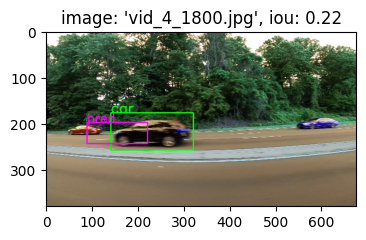

In [31]:
show_pred(df_test, model_1)

### Modelo mejorado model_2

In [32]:
# model=Sequential()
# model.add(tensorflow.keras.Input(shape=(224,224,3)))
# model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
# model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
# model.add(MaxPool2D(2,2))
# model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
# model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
# model.add(MaxPool2D(2,2))
# model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
# model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
# model.add(MaxPool2D(2,2))
# model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
# model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
# model.add(Flatten())
# model.add(Dense(1024,activation="relu"))
# model.add(Dropout(.1))
# model.add(Dense(512,activation="relu"))
# model.add(Dropout(.1))
# model.add(Dense(256,activation="relu"))
# model.add(Dropout(.1))
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(.1))
# model.add(Dense(64,activation="relu"))
# model.add(Dropout(.1))
# model.add(Dense(32,activation="relu"))
# model.add(Dropout(.1))
# model.add(Dense(4,activation="sigmoid"))

# opt=Adam(learning_rate=0.0001)
# model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

# print(model.summary())

model=Sequential()
model.add(tensorflow.keras.Input(shape=(224,224,3)))
model.add(Conv2D(16,(3,3),activation="relu",padding="same"))
model.add(Conv2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(.1))
model.add(Dense(128,activation="relu"))
model.add(Dropout(.1))
model.add(Dense(64,activation="relu"))
model.add(Dropout(.1))
model.add(Dense(32,activation="relu"))
model.add(Dropout(.1))
model.add(Dense(4,activation="sigmoid"))

opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [33]:
checkpoint_filepath = 'best_weights.hdf5'

earlyStop = EarlyStopping(monitor='val_accuracy', patience=15, 
                        verbose=1, mode='max',restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      save_weights_only=False, 
                                      monitor='val_accuracy',
                                      mode='max', 
                                      save_best_only=True)
learningrate = ReduceLROnPlateau(monitor='val_accuracy',
                                          mode='max',
                                          min_delta=0.03, patience=3, 
                                          factor=.5,
                                          min_lr=0.00001, verbose=1)

callbacks = [earlyStop, checkpoint, learningrate]

In [34]:
epochs = 10
hist = model.fit(train_images,
                train_targets,
                validation_data=(val_images,val_targets),
                batch_size=10,
                epochs=epochs,
                callbacks=callbacks,
                verbose=1)

Epoch 1/10
93/93 [==============================] - 13s 49ms/step - loss: 0.0624 - accuracy: 0.4774 - val_loss: 0.0558 - val_accuracy: 0.5775 - lr: 1.0000e-04
Epoch 2/10
93/93 [==============================] - 3s 36ms/step - loss: 0.0554 - accuracy: 0.5387 - val_loss: 0.0521 - val_accuracy: 0.5775 - lr: 1.0000e-04
Epoch 3/10
93/93 [==============================] - 4s 40ms/step - loss: 0.0545 - accuracy: 0.5602 - val_loss: 0.0522 - val_accuracy: 0.6524 - lr: 1.0000e-04
Epoch 4/10
93/93 [==============================] - 3s 36ms/step - loss: 0.0519 - accuracy: 0.6032 - val_loss: 0.0504 - val_accuracy: 0.5882 - lr: 1.0000e-04
Epoch 5/10
93/93 [==============================] - 3s 36ms/step - loss: 0.0509 - accuracy: 0.6011 - val_loss: 0.0484 - val_accuracy: 0.5668 - lr: 1.0000e-04
Epoch 6/10
93/93 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.5989
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
93/93 [==============================] 

47/47 [==============================] - 1s 13ms/step - loss: 0.0462 - accuracy: 0.6524
Error (test):0.04615801200270653
Accuracy (Test): 0.6524063944816589


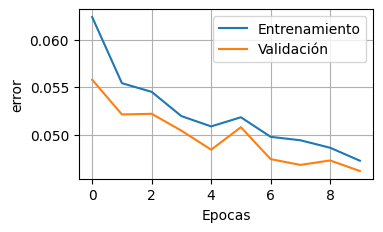

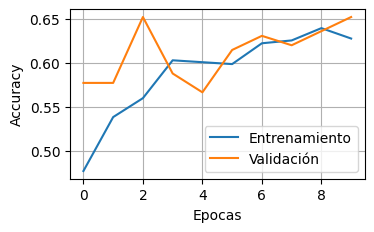

In [35]:
plot_curves(hist.history)
results = model.evaluate(val_images, val_targets, batch_size=4)
print(f'Error (test):{results[0]}\nAccuracy (Test): {results[1]}')

In [36]:
# model_2 = model
# model_2.save('model_2.h5')

# Cargar el modelo
model_2 = load_model('model_2.h5')

1/1 [==============================] - 0s 442ms/step


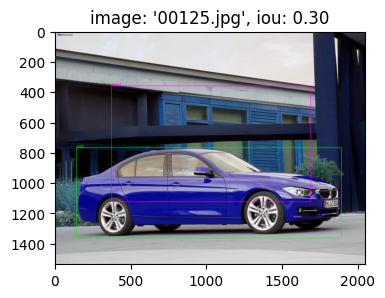

In [37]:
show_pred(df_test, model_2)

### Modelo con Data Augmentation model_3

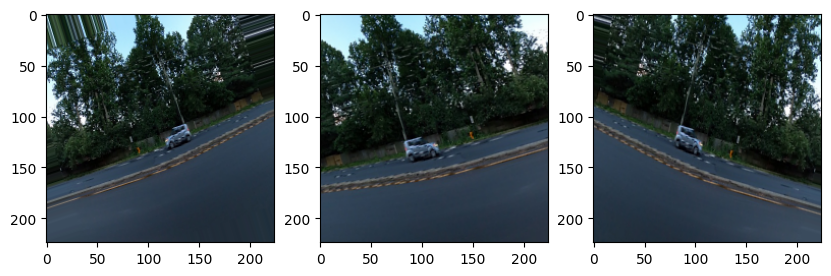

In [38]:
# ImageDataGenerator rotation
aug = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def show_augmented_image(image_path):

  #Loads in image path
  img = load_img(image_path, target_size= (224,224))
  img_tensor = img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  #Uses ImageDataGenerator to flip the images
  #Creates our batch of one image
  pic = aug.flow(img_tensor, batch_size =1)
  plt.figure(figsize=(10,8))
  #Plots our figures
  for i in range(1,4):
    plt.subplot(1, 3, i)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    plt.imshow(image_)
  plt.show()

show_augmented_image(df.image[22])

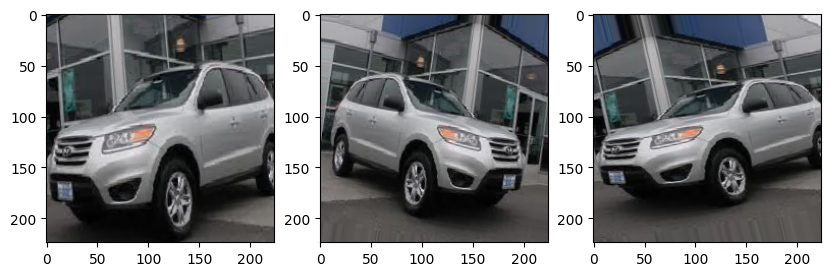

In [39]:
show_augmented_image(df.image[1122])

In [40]:
model=Sequential()
model.add(tensorflow.keras.Input(shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Conv2D(512,(3,3),activation="relu",padding="same"))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(4,activation="sigmoid"))

opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [41]:
checkpoint_filepath = 'best_weights.hdf5'

earlyStop = EarlyStopping(monitor='val_accuracy', patience=15, 
                        verbose=1, mode='max',restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      save_weights_only=False, 
                                      monitor='val_accuracy',
                                      mode='max', 
                                      save_best_only=True)
learningrate = ReduceLROnPlateau(monitor='val_accuracy',
                                          mode='max',
                                          min_delta=0.03, patience=3, 
                                          factor=.5,
                                          min_lr=0.00001, verbose=1)

callbacks = [earlyStop, checkpoint, learningrate]

hist = model.fit(aug.flow(train_images,train_targets),
                 validation_data=(val_images,val_targets),
                 batch_size=16,
                 epochs=10,
                 callbacks=callbacks,
                 verbose=1)

Epoch 1/10
30/30 [==============================] - 45s 954ms/step - loss: 0.0603 - accuracy: 0.5710 - val_loss: 0.0549 - val_accuracy: 0.5775 - lr: 1.0000e-04
Epoch 2/10
30/30 [==============================] - 21s 705ms/step - loss: 0.0515 - accuracy: 0.6065 - val_loss: 0.0507 - val_accuracy: 0.5989 - lr: 1.0000e-04
Epoch 3/10
30/30 [==============================] - 22s 732ms/step - loss: 0.0500 - accuracy: 0.6430 - val_loss: 0.0498 - val_accuracy: 0.6364 - lr: 1.0000e-04
Epoch 4/10
30/30 [==============================] - 14s 470ms/step - loss: 0.0497 - accuracy: 0.6559 - val_loss: 0.0524 - val_accuracy: 0.6364 - lr: 1.0000e-04
Epoch 5/10
30/30 [==============================] - 14s 466ms/step - loss: 0.0501 - accuracy: 0.6591 - val_loss: 0.0495 - val_accuracy: 0.6364 - lr: 1.0000e-04
Epoch 6/10
30/30 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.6473
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
30/30 [=======================

47/47 [==============================] - 1s 20ms/step - loss: 0.0474 - accuracy: 0.6364
Error (test):0.047443706542253494
Accuracy (Test): 0.6363636255264282


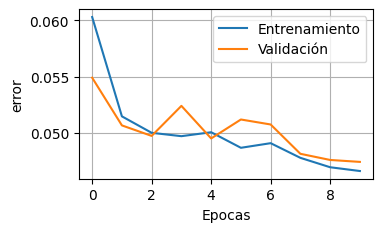

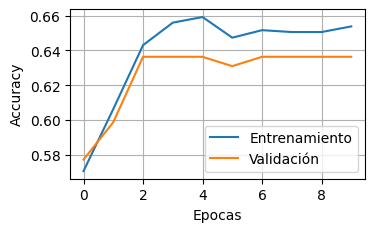

In [42]:
plot_curves(hist.history)
results = model.evaluate(val_images, val_targets, batch_size=4)
print(f'Error (test):{results[0]}\nAccuracy (Test): {results[1]}')

In [43]:
# Guardar el modelo
# model_3 = model
# model_3.save('model_3.h5')

# Cargar el modelo
model_3 = load_model('model_3.h5')

1/1 [==============================] - 0s 23ms/step


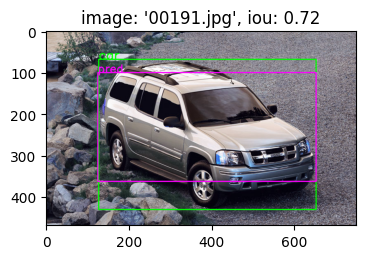

In [178]:
show_pred(df_test, model_3)

### Comparación visual de modelos 

1/1 [==============================] - 0s 20ms/step


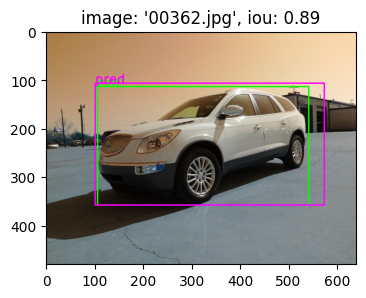

In [123]:
show_pred(df_test, model_1, a= 735)

1/1 [==============================] - 0s 56ms/step


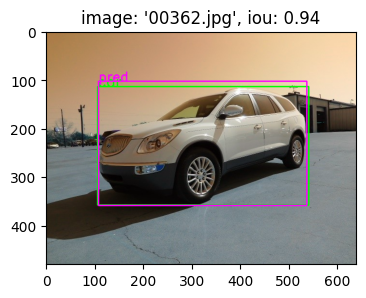

In [124]:
show_pred(df_test, model_2, a= 735)

1/1 [==============================] - 0s 41ms/step


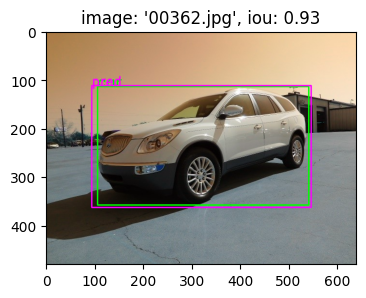

In [122]:
show_pred(df_test, model_3, a= 735)

1/1 [==============================] - 0s 20ms/step


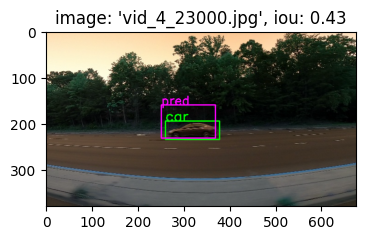

In [67]:
show_pred(df_test, model_1, a= 63)

1/1 [==============================] - 0s 56ms/step


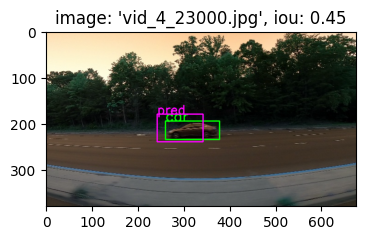

In [66]:
show_pred(df_test, model_2, a= 63)

1/1 [==============================] - 0s 35ms/step


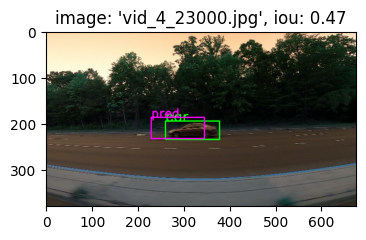

In [65]:
show_pred(df_test, model_3, a= 63)

1/1 [==============================] - 0s 27ms/step


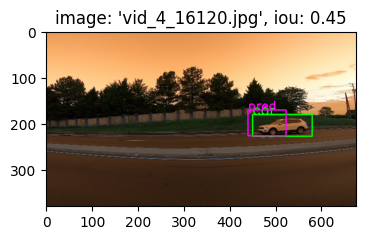

In [62]:
show_pred(df_test, model_1, a= 277)

1/1 [==============================] - 0s 42ms/step


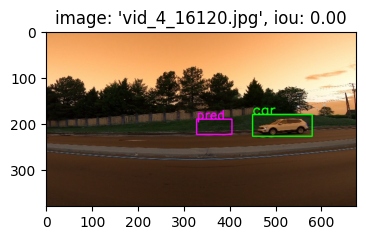

In [61]:
show_pred(df_test, model_2, a= 277)

1/1 [==============================] - 0s 37ms/step


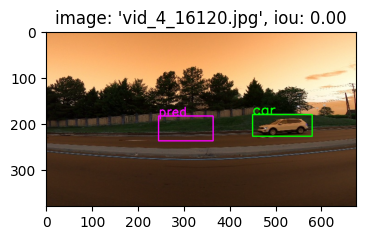

In [60]:
show_pred(df_test, model_3, a= 277)

## Transfer Learning
### ResNet50

In [161]:
base_model = tf.keras.applications.ResNet50(include_top=False,
input_shape=(224,224,3),
weights='imagenet')

base_model.trainable=False

In [162]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [163]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(4,activation="sigmoid"))
opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_15 (Dense)            (None, 1024)              102761472 
                                                                 
 dense_16 (Dense)            (None, 512)               524800    
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 128)              

In [164]:
hist = model.fit(train_images,
                 train_targets,
                 validation_data=(val_images,val_targets),
                 batch_size=4,
                 epochs=10,
                 callbacks=callbacks,
                 verbose=1)

Epoch 1/10
233/233 [==============================] - 21s 64ms/step - loss: 0.0584 - accuracy: 0.5892 - val_loss: 0.0598 - val_accuracy: 0.3904 - lr: 1.0000e-04
Epoch 2/10
233/233 [==============================] - 11s 46ms/step - loss: 0.0524 - accuracy: 0.5968 - val_loss: 0.0485 - val_accuracy: 0.5722 - lr: 1.0000e-04
Epoch 3/10
233/233 [==============================] - 11s 46ms/step - loss: 0.0505 - accuracy: 0.6022 - val_loss: 0.0499 - val_accuracy: 0.5829 - lr: 1.0000e-04
Epoch 4/10
233/233 [==============================] - 17s 74ms/step - loss: 0.0494 - accuracy: 0.6258 - val_loss: 0.0519 - val_accuracy: 0.6471 - lr: 1.0000e-04
Epoch 5/10
233/233 [==============================] - 10s 41ms/step - loss: 0.0482 - accuracy: 0.6613 - val_loss: 0.0479 - val_accuracy: 0.6310 - lr: 1.0000e-04
Epoch 6/10
233/233 [==============================] - 10s 43ms/step - loss: 0.0473 - accuracy: 0.6312 - val_loss: 0.0473 - val_accuracy: 0.6364 - lr: 1.0000e-04
Epoch 7/10
233/233 [==============

47/47 [==============================] - 1s 21ms/step - loss: 0.0478 - accuracy: 0.6524
Error (test):0.04784032702445984
Accuracy (Test): 0.6524063944816589


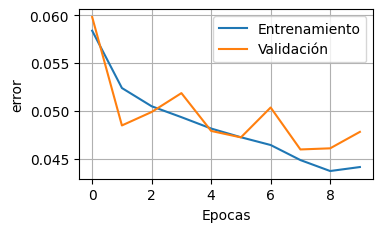

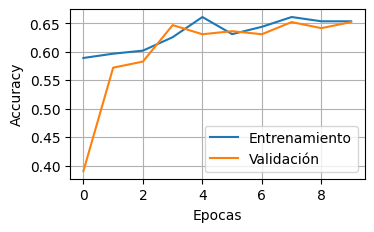

In [165]:
plot_curves(hist.history)
results = model.evaluate(val_images, val_targets, batch_size=4)
print(f'Error (test):{results[0]}\nAccuracy (Test): {results[1]}')

In [166]:
# Guardar el modelo
# model_TransfLearn_ResNet50 = model
# model_TransfLearn_ResNet50.save('model_TransfLearn_ResNet50.h5')

# Cargar el modelo
model_TransfLearn_ResNet50 = load_model('model_TransfLearn_ResNet50.h5')

1/1 [==============================] - 2s 2s/step


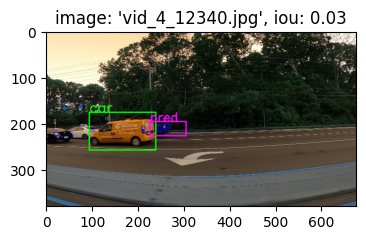

In [167]:
show_pred(df_test, model_TransfLearn_ResNet50)

## Fine Tuning
### ResNet50

In [179]:
print(f"Cantidad de capas de ResNet50: {len(base_model.layers)}")

Cantidad de capas de ResNet50: 175


In [169]:
base_model = tf.keras.applications.ResNet50(include_top=False,
input_shape=(224,224,3),
weights='imagenet')

# Descongelar las últimas 
for layer in base_model.layers[:-48]: layer.trainable = False

In [180]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [171]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(4,activation="sigmoid"))
opt=Adam(learning_rate=0.0001)
model.compile(loss="mse",optimizer=opt, metrics=['accuracy'])

hist = model.fit(train_images,
                 train_targets,
                 validation_data=(val_images,val_targets),
                 batch_size=4,
                 epochs=10,
                 callbacks=callbacks,
                 verbose=1)

Epoch 1/10
233/233 [==============================] - 34s 77ms/step - loss: 0.0589 - accuracy: 0.5774 - val_loss: 0.0600 - val_accuracy: 0.5775 - lr: 1.0000e-04
Epoch 2/10
233/233 [==============================] - 16s 67ms/step - loss: 0.0538 - accuracy: 0.5935 - val_loss: 0.0470 - val_accuracy: 0.6471 - lr: 1.0000e-04
Epoch 3/10
233/233 [==============================] - 15s 65ms/step - loss: 0.0503 - accuracy: 0.6269 - val_loss: 0.0449 - val_accuracy: 0.6096 - lr: 1.0000e-04
Epoch 4/10
233/233 [==============================] - 15s 63ms/step - loss: 0.0465 - accuracy: 0.6323 - val_loss: 0.0625 - val_accuracy: 0.6096 - lr: 1.0000e-04
Epoch 5/10
233/233 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.6258
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
233/233 [==============================] - 15s 64ms/step - loss: 0.0465 - accuracy: 0.6258 - val_loss: 0.0494 - val_accuracy: 0.5668 - lr: 1.0000e-04
Epoch 6/10
233/233 [==============

47/47 [==============================] - 1s 25ms/step - loss: 0.0428 - accuracy: 0.6845
Error (test):0.04283326119184494
Accuracy (Test): 0.6844919919967651


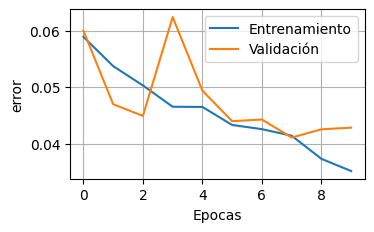

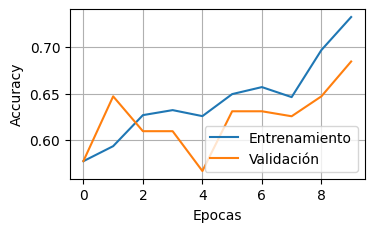

In [175]:
plot_curves(hist.history)
results = model.evaluate(val_images, val_targets, batch_size=4)
print(f'Error (test):{results[0]}\nAccuracy (Test): {results[1]}')

In [173]:
# Guardar el modelo
# model_FineTunning_ResNet50 = model
# model_FineTunning_ResNet50.save('model_FineTunning_ResNet50.h5')

# Cargar el modelo
model_FineTunning_ResNet50 = model_load('model_FineTunning_ResNet50.h5')

1/1 [==============================] - 0s 24ms/step


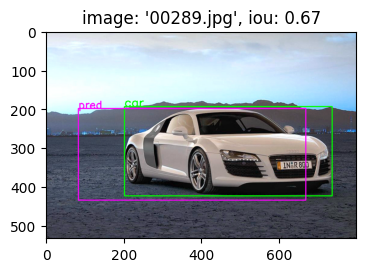

In [188]:
show_pred(df_test, model_FineTunning_ResNet50)

## Rendimiento de los modelos

| Modelo                     | accuracy | validation accuracy |
|----------------------------|----------|---------------------|
| model_1                    | 77,88%    | 63,54%             |
| model_2                    | 63,27%    | 64,64%             |
| model_3                    | 65,38%    | 62,98%             |
| model_TransfLearn_ResNet50 | 65,27%    |  65,24%            |
| model_FineTunning_ResNet50 | 73,23%    | 68,45%.            |